In [ ]:
import matplotlib.pyplot as plt
import sparknlp

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, array_contains, split
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, RegexTokenizer, HashingTF, StringIndexer

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline

In [4]:
spark = SparkSession.builder \
.appName("read_tsv") \
.master('local[*]') \
.config('spark.sql.execution.arrow.pyspark.enabled', True) \
.config('spark.sql.session.timeZone', 'UTC') \
.config('spark.driver.memory','32G') \
.config('spark.ui.showConsoleProgress', True) \
.config('spark.sql.repl.eagerEval.enabled', True) \
.getOrCreate()

In [94]:
spark = SparkSession.builder \
    .appName("read_tsv") \
    .master('local[*]') \
    .config('spark.sql.execution.arrow.pyspark.enabled', True) \
    .config('spark.sql.session.timeZone', 'UTC') \
    .config('spark.driver.memory', '32G') \
    .config('spark.ui.showConsoleProgress', True) \
    .config('spark.sql.repl.eagerEval.enabled', True) \
    .config('spark.sql.shuffle.partitions', '500') \
    .config('spark.default.parallelism', '100') \
    .config('spark.serializer', 'org.apache.spark.serializer.KryoSerializer') \
    .config('spark.memory.fraction', '0.6') \
    .config('spark.memory.storageFraction', '0.5') \
    .getOrCreate()


In [95]:
# Read tsv file
data1 = spark.read.option("delimiter", "\t").csv("gs://msca-bdp-student-gcs/group10-amazon-review/amazon_reviews_us_Baby_v1_00.tsv", header=True, inferSchema=True)
data2 = spark.read.option("delimiter", "\t").csv("gs://msca-bdp-student-gcs/group10-amazon-review/amazon_reviews_us_Beauty_v1_00.tsv", header=True, inferSchema=True)
data3 = spark.read.option("delimiter", "\t").csv("gs://msca-bdp-student-gcs/group10-amazon-review/amazon_reviews_us_Camera_v1_00.tsv", header=True, inferSchema=True)
data4 = spark.read.option("delimiter", "\t").csv("gs://msca-bdp-student-gcs/group10-amazon-review/amazon_reviews_us_Electronics_v1_00.tsv", header=True, inferSchema=True)
data5 = spark.read.option("delimiter", "\t").csv("gs://msca-bdp-student-gcs/group10-amazon-review/amazon_reviews_us_Furniture_v1_00.tsv", header=True, inferSchema=True)

In [96]:
data = data1.union(data2).union(data3).union(data4).union(data5)

## Data Cleaning

In [97]:
#data cleaning

from pyspark.sql.functions import col

#check any NA values
missing_count = [data.filter(col(customer_id).isNull()).count() for customer_id in data.columns]
missing_values = dict(zip(data.columns, missing_count))

# missing value counts
for column, count in missing_values.items():
    print(f"Missing values in '{column}': {count}")
    

#remove missing values
data_1 = data.dropna()

# Check for duplicates based on a column

data_dup = data_1.dropDuplicates(subset=["review_body", "review_id"])
# Count rows and see if duplicate rows were removed
data_dup.count()

from pyspark.sql.functions import length
data_text = data_dup.filter(length(data_dup["review_body"]) > 5)

# Count rows
data_text.count()


# convert to all lowercase text for consistency

from pyspark.sql.functions import lower
 
cols_lower = ["review_body", "product_title", "product_category","review_headline"]

# Apply lowercase conversion to each column
for col in cols_lower:
    data_text = data_text.withColumn(col, lower(data_text[col]))
    
    
#remove any unwanted characters

from pyspark.sql.functions import regexp_replace

cols_lower = ["review_body", "product_title", "product_category","review_headline"]

# Pattern for text cleaning
pattern = "[^a-zA-Z0-9\\s]"

# Apply text cleaning pattern to each column
for col in cols_lower:
    data_text = data_text.withColumn(col, regexp_replace(data_text[col], pattern, ""))


Missing values in 'marketplace': 0
Missing values in 'customer_id': 0
Missing values in 'review_id': 0
Missing values in 'product_id': 0
Missing values in 'product_parent': 0
Missing values in 'product_title': 0
Missing values in 'product_category': 223
Missing values in 'star_rating': 223
Missing values in 'helpful_votes': 224
Missing values in 'total_votes': 224
Missing values in 'vine': 224
Missing values in 'verified_purchase': 224
Missing values in 'review_headline': 237
Missing values in 'review_body': 1579
Missing values in 'review_date': 836


## Sentiment Analysis

In [99]:
# Define Spark NLP pipeline
document_assembler = DocumentAssembler() \
    .setInputCol("review_body") \
    .setOutputCol("document")

sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

In [100]:
from sparknlp.annotator import UniversalSentenceEncoder

# Use Universal Sentence Encoder for embeddings
sentence_embeddings = UniversalSentenceEncoder.pretrained() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence_embeddings")

sentiment_detector = SentimentDLModel.pretrained("sentimentdl_use_twitter", "en") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("sentiment")

pipeline = Pipeline(stages=[
    document_assembler,
    sentence_detector,
    tokenizer,
    sentence_embeddings,
    sentiment_detector
])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[OK!]


In [101]:
# Fit pipeline to data
model = pipeline.fit(data_text)
result = model.transform(data_text)

In [36]:
# Show results
result.select("review_body", "sentiment.result").show(n = 10)

+--------------------+----------+
|         review_body|    result|
+--------------------+----------+
| see update below...|[negative]|
| update december ...|[negative]|
|    update 42308 ...|[negative]|
|important  these ...|[positive]|
|2 the price  my d...|[negative]|
|warning the item ...|[positive]|
|1if youre looking...|[negative]|
|gotitfreefromsecr...|[positive]|
|update they send ...|[negative]|
|gotitfree thank y...|[positive]|
+--------------------+----------+
only showing top 10 rows



In [58]:
result.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)


## 2. Model Building with Spark ML

In [39]:
data_text_1 = data_text_1.withColumn("star_rating", col("star_rating").cast(IntegerType()))

In [40]:
# Tokenize text
tokenizer = Tokenizer(inputCol="review_body", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
vectorizer = CountVectorizer(inputCol="filtered", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")

In [41]:
# Classifier
lr = LogisticRegression(featuresCol="features", labelCol="star_rating")

# Pipeline
pipeline = Pipeline(stages=[tokenizer, remover, vectorizer, idf, lr])

# Split data
(trainingData, testData) = data_text_1.randomSplit([0.7, 0.3], seed = 100)

In [ ]:
# Train model
model = pipeline.fit(trainingData)

# Make predictions
predictions = model.transform(testData)

# Evaluate model
evaluator = MulticlassClassificationEvaluator(labelCol="star_rating", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

23/11/28 19:27:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/11/28 19:28:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/11/28 19:30:08 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 6.9 MiB
23/11/28 19:31:15 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 6.9 MiB
23/11/28 19:31:16 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 6.9 MiB
23/11/28 19:32:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 6.9 MiB
23/11/28 19:32:35 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 6.9 MiB
23/11/28 19:32:43 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 6.9 MiB
23/11/28 19:32:44 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary w

In [43]:
accuracy

0.6881517015341926

## Analyze Sentiment Accuracy

### Convert Sentiment Label

In [104]:
# Explode the sentiment array to access its elements
exploded_df = result.withColumn("sentiment_exploded", explode(col("sentiment")))

# Select the review_body and the result field from the exploded sentiment
selected_df = exploded_df.select(
    col("product_id"),
    col("product_category"),
    col("star_rating"),
    col("review_date"),
    col("review_body"),
    col("sentiment_exploded.result").alias("sentiment_result")
)

In [80]:
selected_df.printSchema()

root
 |-- product_id: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- review_date: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- sentiment_result: string (nullable = true)



In [ ]:
# selected_df.cache()
selected_df.select("sentiment_result").groupBy("sentiment_result").count().show()

In [204]:
# Assuming selected_df is your DataFrame and 'sentiment_result' is the column with sentiment labels
sentiment_counts = selected_df.groupBy("sentiment_result").count()
# Collect the data to the driver
sentiment_counts_list = sentiment_counts.collect()

Exception ignored in: <function JavaWrapper.__del__ at 0x7ff94b217700>
Traceback (most recent call last):
  File "/usr/lib/spark/python/pyspark/ml/wrapper.py", line 39, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'Tokenizer' object has no attribute '_java_obj'
Exception ignored in: <function JavaWrapper.__del__ at 0x7ff94b217700>
Traceback (most recent call last):
  File "/usr/lib/spark/python/pyspark/ml/wrapper.py", line 39, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'Tokenizer' object has no attribute '_java_obj'


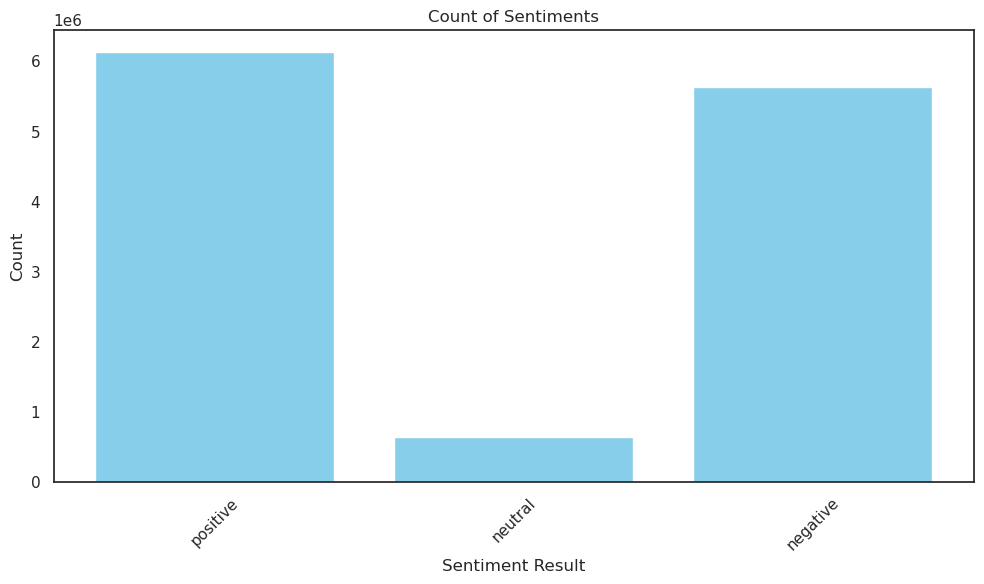

Exception ignored in: <function Pool.__del__ at 0x7ff94b1a3280>
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.8/multiprocessing/pool.py", line 268, in __del__
    self._change_notifier.put(None)
  File "/opt/conda/miniconda3/lib/python3.8/multiprocessing/queues.py", line 368, in put
    self._writer.send_bytes(obj)
  File "/opt/conda/miniconda3/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/miniconda3/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/miniconda3/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Exception ignored in: <function Pool.__del__ at 0x7ff94b1a3280>
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.8/multiprocessing/pool.py", line 268, in __del__
    self._change_no

In [205]:
sentiment_labels = [row['sentiment_result'] for row in sentiment_counts_list]
counts = [row['count'] for row in sentiment_counts_list]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(sentiment_labels, counts, color='skyblue')
plt.xlabel('Sentiment Result')
plt.ylabel('Count')
plt.title('Count of Sentiments')
plt.xticks(rotation=45)
plt.tight_layout()

In [ ]:
# Text preprocessing
tokenizer = Tokenizer(inputCol="review_body", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features")

# Label encoding
# Check if the 'label' column exists
if 'label' in selected_df.columns:
    # Drop the existing 'label' column
    selected_df = selected_df.drop('label')

# Now apply the StringIndexer
label_indexer = StringIndexer(inputCol="sentiment_result", outputCol="label").fit(selected_df)
selected_df = label_indexer.transform(selected_df)

# Create an inverse map from numeric label to original label
# label_dict = {idx: label for label, idx in label_indexer.labels}
# Assuming label_indexer is the fitted StringIndexerModel
label_dict = {idx: label for idx, label in enumerate(label_indexer.labels)}

# Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="label", family="multinomial")

# Pipeline
pipeline = Pipeline(stages=[tokenizer, remover, vectorizer, label_indexer, lr])

# Split data into training and test sets
train_data, test_data = selected_df.randomSplit([0.7, 0.3], seed=12345)

# Check if the 'label' column exists
if 'label' in train_data.columns:
    # Drop the existing 'label' column
    train_data = train_data.drop('label')
    
# Check if the 'label' column exists
if 'label' in test_data.columns:
    # Drop the existing 'label' column
    test_data = test_data.drop('label')

# Train model
model = pipeline.fit(train_data)

# Predictions
predictions = model.transform(test_data)

# Evaluate model
# Use MulticlassClassificationEvaluator for multi-class problems
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Accuracy: ", accuracy)


In [141]:
# Convert DataFrame to RDD for MulticlassMetrics
predictionAndLabels = predictions.select("prediction", "label").rdd.map(lambda x: (float(x[0]), float(x[1])))

# Instantiate MulticlassMetrics
metrics = MulticlassMetrics(predictionAndLabels)

# Calculate metrics for each label
for label_idx, label_name in label_dict.items():
    precision = metrics.precision(label_idx)
    recall = metrics.recall(label_idx)
    f1Score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    print(f"Class {label_name} (Index {label_idx}): Precision = {precision}, Recall = {recall}, F1 Score = {f1Score}")

# Overall statistics
accuracy = metrics.accuracy
print("Overall Accuracy = %s" % accuracy)

23/11/28 01:08:17 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 9.5 MiB
23/11/28 01:08:17 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 9.5 MiB


Class positive (Index 0): Precision = 0.8134483314231166, Recall = 0.8790540895710681, F1 Score = 0.8449796863182262
Class negative (Index 1): Precision = 0.763232640513266, Recall = 0.7294681876008027, F1 Score = 0.7459685430688879
Class neutral (Index 2): Precision = 0.14800381740098617, Recall = 0.06459114257948077, F1 Score = 0.08993379403663074
Overall Accuracy = 0.7800860932363265


In [123]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col

# Convert DataFrame to RDD
predictionAndLabels = predictions.select("prediction", "label").rdd.map(lambda x: (x[0], x[1]))

# Instantiate MulticlassMetrics
metrics = MulticlassMetrics(predictionAndLabels)

# Calculate metrics for each label
labels = predictions.select("label").distinct().rdd.flatMap(lambda x: x).collect()
for label in sorted(labels):
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1Score = metrics.fMeasure(label)
    print("Class %s: Precision = %s, Recall = %s, F1 Score = %s" % (label, precision, recall, f1Score))

# Overall statistics
accuracy = metrics.accuracy
print("Accuracy = %s" % accuracy)


23/11/28 00:33:59 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 9.5 MiB
23/11/28 00:34:02 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 9.5 MiB


Class 0.0: Precision = 0.813536517059153, Recall = 0.8780027859545837, F1 Score = 0.8445412142432784
Class 1.0: Precision = 0.7619407631415103, Recall = 0.7295799688077204, F1 Score = 0.745409307827222
Class 2.0: Precision = 0.1448977981216952, Recall = 0.06372344856309871, F1 Score = 0.08851818817346864
Accuracy = 0.7794642874278158


### Drop Neutral

In [143]:
selected_df_filtered = selected_df.filter(selected_df.sentiment_result != "neutral")

In [159]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Assuming your Spark session is initialized as 'spark' and DataFrame as 'selected_df'

# Text preprocessing
tokenizer = Tokenizer(inputCol="review_body", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features")

# Label encoding
label_indexer = StringIndexer(inputCol="sentiment_result", outputCol="label")

# Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Pipeline
pipeline = Pipeline(stages=[tokenizer, remover, vectorizer, label_indexer, lr])

# Split data into training and test sets
train_data, test_data = selected_df_filtered.randomSplit([0.7, 0.3], seed=12345)

# Check if the 'label' column exists
if 'label' in train_data.columns:
    # Drop the existing 'label' column
    train_data = train_data.drop('label')
    
# Check if the 'label' column exists
if 'label' in test_data.columns:
    # Drop the existing 'label' column
    test_data = test_data.drop('label')

# Train model
model = pipeline.fit(train_data)

# Predictions
predictions = model.transform(test_data)


23/11/28 03:10:37 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.4 MiB
23/11/28 03:10:45 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.4 MiB
23/11/28 03:10:45 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.4 MiB
23/11/28 03:10:51 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.4 MiB
23/11/28 03:10:52 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.4 MiB
23/11/28 03:10:53 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.4 MiB
23/11/28 03:10:53 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.4 MiB
23/11/28 03:10:54 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.4 MiB
23/11/28 03:10:55 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary w

In [160]:
# Evaluate model
evaluator = BinaryClassificationEvaluator()
accuracy = evaluator.evaluate(predictions)

print("Accuracy: ", accuracy)

23/11/28 03:19:59 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.5 MiB


Accuracy:  0.8776766997207375


In [161]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col

# Convert DataFrame to RDD
predictionAndLabels = predictions.select("prediction", "label").rdd.map(lambda x: (x[0], x[1]))


# Instantiate MulticlassMetrics
metrics = MulticlassMetrics(predictionAndLabels)

# Calculate metrics for each label
labels = predictions.select("label").distinct().rdd.flatMap(lambda x: x).collect()
for label in sorted(labels):
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1Score = metrics.fMeasure(label)
    print("Class %s: Precision = %s, Recall = %s, F1 Score = %s" % (label, precision, recall, f1Score))

# Overall statistics
accuracy = metrics.accuracy
print("Accuracy = %s" % accuracy)

23/11/28 03:20:09 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.5 MiB
23/11/28 03:20:10 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.5 MiB


Class 0.0: Precision = 0.8505857842983452, Recall = 0.8910864077414604, F1 Score = 0.8703651978489444
Class 1.0: Precision = 0.8092345778519819, Recall = 0.7469404456347878, F1 Score = 0.776840685759763
Accuracy = 0.8359994557414203


### Trend Analysis

In [86]:
from pyspark.sql.functions import to_date

# Assuming your timestamp column is named 'date' and sentiment column is 'sentiment'
selected_df = selected_df.withColumn("date", to_date(selected_df.review_date, "yyyy-MM-dd"))

In [19]:
selected_df

DataFrame[product_id: string, review_date: string, review_body: string, sentiment_result: string, date: date]

In [42]:
yearly_counts = selected_df.groupBy(F.year("date").alias("year"), "sentiment_result").count().orderBy(F.desc("year"),"sentiment_result")

In [45]:
pivot_data = yearly_counts.groupBy("year").pivot("sentiment_result").sum("count").orderBy(F.desc("year"))
pivot_data.show()

+----+--------+-------+--------+
|year|negative|neutral|positive|
+----+--------+-------+--------+
|2015|  164161|  22702|  306424|
|2014|  165461|  24346|  279722|
|2013|  117250|  18597|  178020|
|2012|   56276|   8766|   76745|
|2011|   42177|   6858|   55423|
|2010|   22946|   3753|   32084|
|2009|   13629|   2460|   20776|
|2008|    9719|   1863|   16076|
|2007|    7476|   1395|   11231|
|2006|    5334|    892|    7363|
|2005|    7783|   1335|   10292|
|2004|    6379|   1159|    8784|
|2003|    4155|    823|    6149|
|2002|    2577|    507|    3675|
|2001|     678|    151|    1184|
|2000|      69|     10|     154|
|1999|      20|      7|      85|
+----+--------+-------+--------+



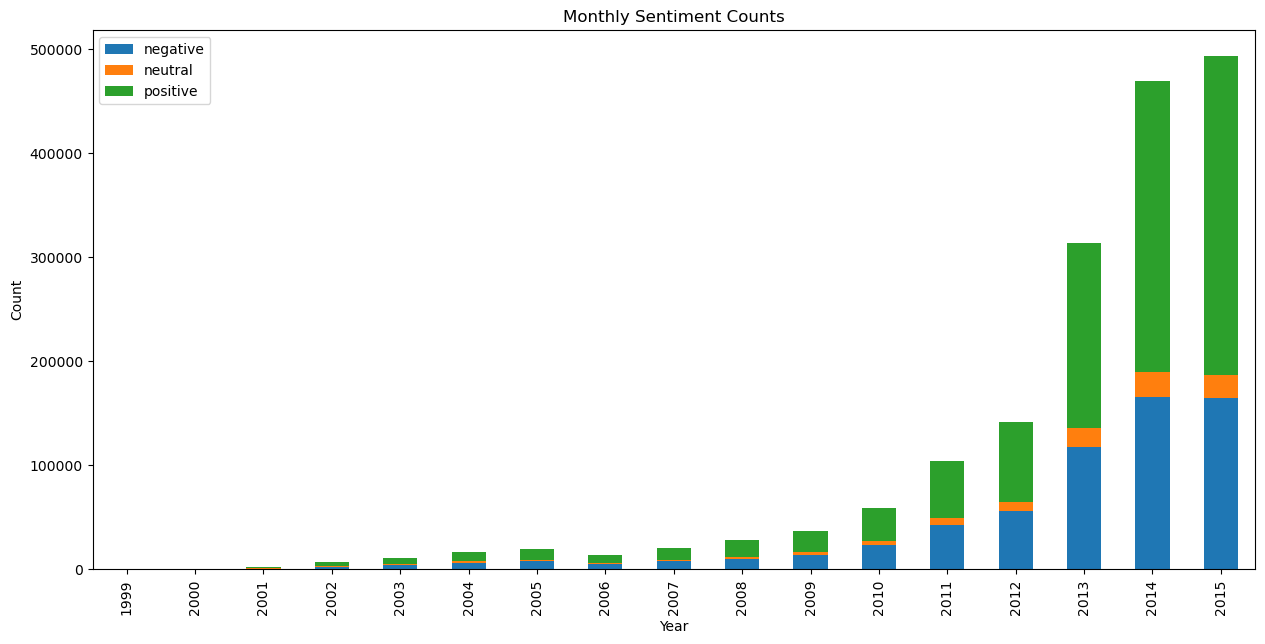

In [46]:
pivoted_df = pivot_data.toPandas()

# Set the 'year' and 'month' as the index for plotting
pivoted_df.set_index(['year'], inplace=True)

# Sort the DataFrame by index for better visualization
pivoted_df.sort_index(inplace=True)

# Plotting
pivoted_df.plot(kind='bar', stacked=True, figsize=(15, 7))

# Set the labels and title
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Monthly Sentiment Counts')

# Show the plot
plt.show()

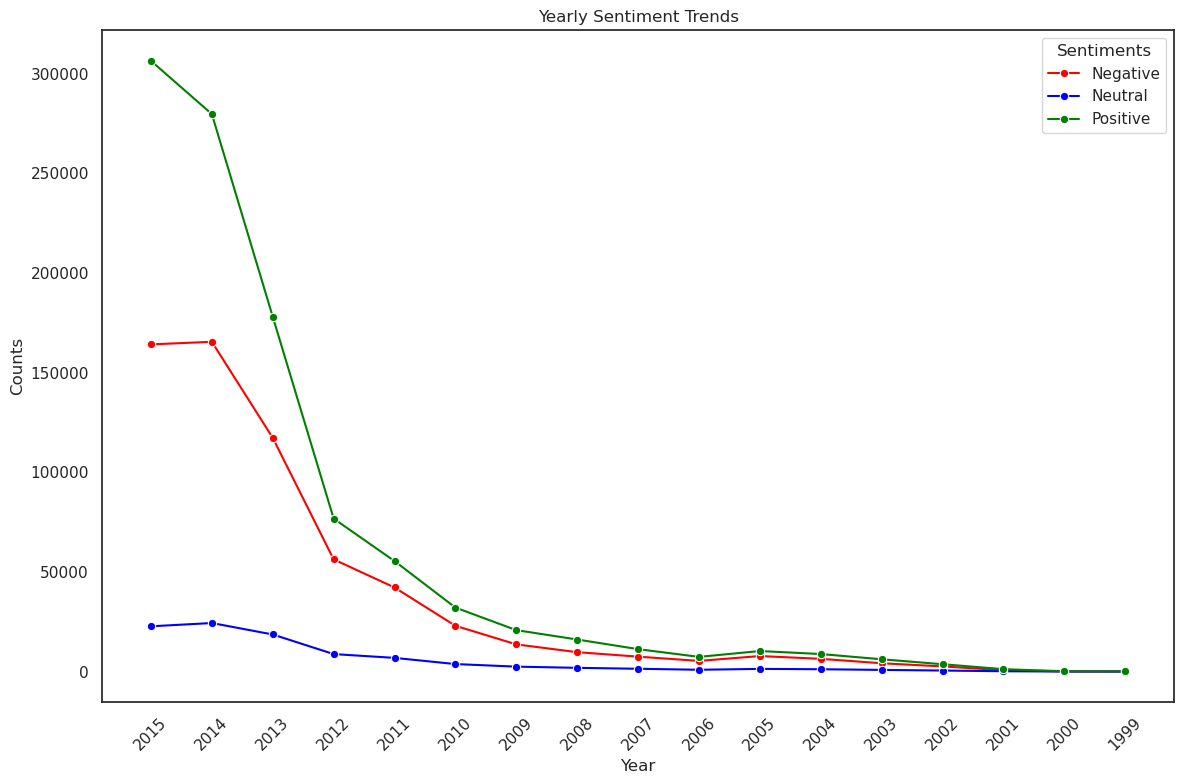

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'yearly_sentiment_counts' is your Spark DataFrame
# Convert the Spark DataFrame to a Pandas DataFrame
pdf = pivot_data.toPandas()

# Ensure 'year' is of type string for plotting purposes
pdf['year'] = pdf['year'].astype(str)

# Set the style
sns.set(style="whiteg")

# Plot
plt.figure(figsize=(12, 8))

# Plotting each sentiment trend
sns.lineplot(x='year', y='negative', data=pdf, marker='o', label='Negative', color='red')
sns.lineplot(x='year', y='neutral', data=pdf, marker='o', label='Neutral', color='blue')
sns.lineplot(x='year', y='positive', data=pdf, marker='o', label='Positive', color='green')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Counts')
plt.title('Yearly Sentiment Trends')
plt.xticks(rotation=45)
plt.legend(title='Sentiments')

# Show the plot
plt.tight_layout()
plt.show()


### Trend Analysis in 2015

In [98]:
selected_df_2015 = selected_df.filter(F.year("date").alias("year") == 2015)
monthly_counts = selected_df_2015.groupBy(F.month("date").alias("month"), F.year("date").alias("year"), "sentiment_result").count().orderBy(F.desc("year"), "month", "sentiment_result")
pivot_data = monthly_counts.groupBy("year", "month").pivot("sentiment_result").sum("count")

In [99]:
pdf = pivot_data.toPandas()
pdf = pdf.sort_values('month', ascending=False)
pdf['month'] = pdf['month'].astype(str)

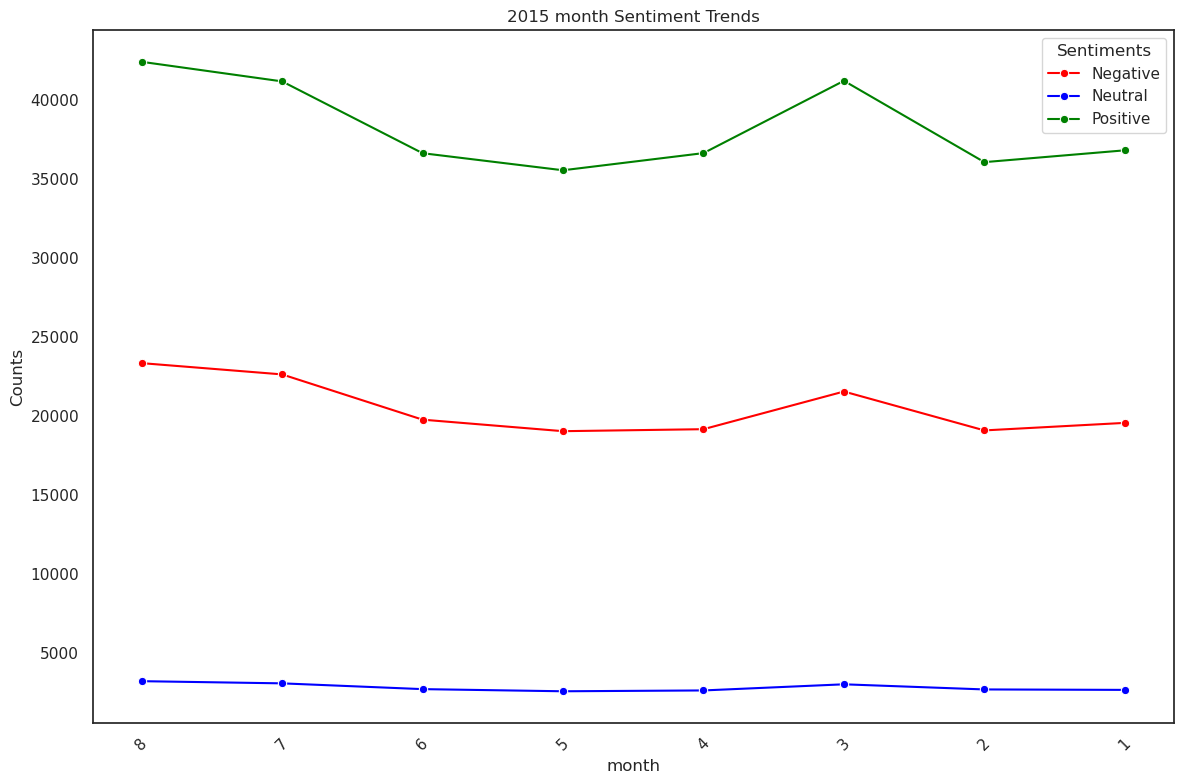

In [101]:
# Set the style
sns.set(style="white")

# Plot
plt.figure(figsize=(12, 8))

# Plotting each sentiment trend
sns.lineplot(x='month', y='negative', data=pdf, marker='o', label='Negative', color='red')
sns.lineplot(x='month', y='neutral', data=pdf, marker='o', label='Neutral', color='blue')
sns.lineplot(x='month', y='positive', data=pdf, marker='o', label='Positive', color='green')

# Adding labels and title
plt.xlabel('month')
plt.ylabel('Counts')
plt.title('2015 month Sentiment Trends')
plt.xticks(rotation=45)
plt.legend(title='Sentiments')

# Show the plot
plt.tight_layout()
plt.show()

### Trend Analysis in 2012

In [67]:
selected_df_2012 = selected_df.filter(F.year("date").alias("year") == 2012)

In [68]:
selected_df_2012.show()

+----------+-----------+--------------------+----------------+----------+
|product_id|review_date|         review_body|sentiment_result|      date|
+----------+-----------+--------------------+----------------+----------+
|B001156IP4| 2012-10-02|21915br br sorry ...|        negative|2012-10-02|
|B005IOIQWM| 2012-09-10|2t does not fit m...|        negative|2012-09-10|
|B004QDFK8O| 2012-01-13|warning this prod...|        negative|2012-01-13|
|B002VXT8D4| 2012-04-16|a beautiful desig...|        positive|2012-04-16|
|B001190D5Q| 2012-04-04|a little goes a l...|        negative|2012-04-04|
|B009GKSA7K| 2012-10-03|a must have for a...|        positive|2012-10-03|
|B003U6HCGQ| 2012-06-04|a previous review...|        positive|2012-06-04|
|B002NUXHJQ| 2012-09-22|according to the ...|        positive|2012-09-22|
|B00310T2SW| 2012-11-13|after i received ...|        negative|2012-11-13|
|B000LSVJGK| 2012-12-15|after doing much ...|        positive|2012-12-15|
|B005O4BAJ2| 2012-07-01|after going th

In [69]:

# Example for monthly counts
monthly_counts = selected_df_2012.groupBy(F.month("date").alias("month"), F.year("date").alias("year"), "sentiment_result").count().orderBy(F.desc("year"), "month", "sentiment_result")

In [70]:
pivot_data = monthly_counts.groupBy("year", "month").pivot("sentiment_result").sum("count")

In [78]:
pivot_data.orderBy(F.desc("month")).show()

+----+-----+--------+-------+--------+
|year|month|negative|neutral|positive|
+----+-----+--------+-------+--------+
|2012|   12|    9294|   1516|   15036|
|2012|   11|    5875|    951|    8538|
|2012|   10|    4548|    666|    6143|
|2012|    9|    4209|    661|    5534|
|2012|    8|    4444|    684|    5764|
|2012|    7|    4069|    592|    4949|
|2012|    6|    3883|    568|    4770|
|2012|    5|    3872|    550|    4847|
|2012|    4|    3805|    596|    4910|
|2012|    3|    3978|    620|    5370|
|2012|    2|    3856|    586|    4884|
|2012|    1|    4443|    776|    6000|
+----+-----+--------+-------+--------+



In [92]:
pdf = pivot_data.toPandas()
pdf = pdf.sort_values('month', ascending=False)
pdf['month'] = pdf['month'].astype(str)

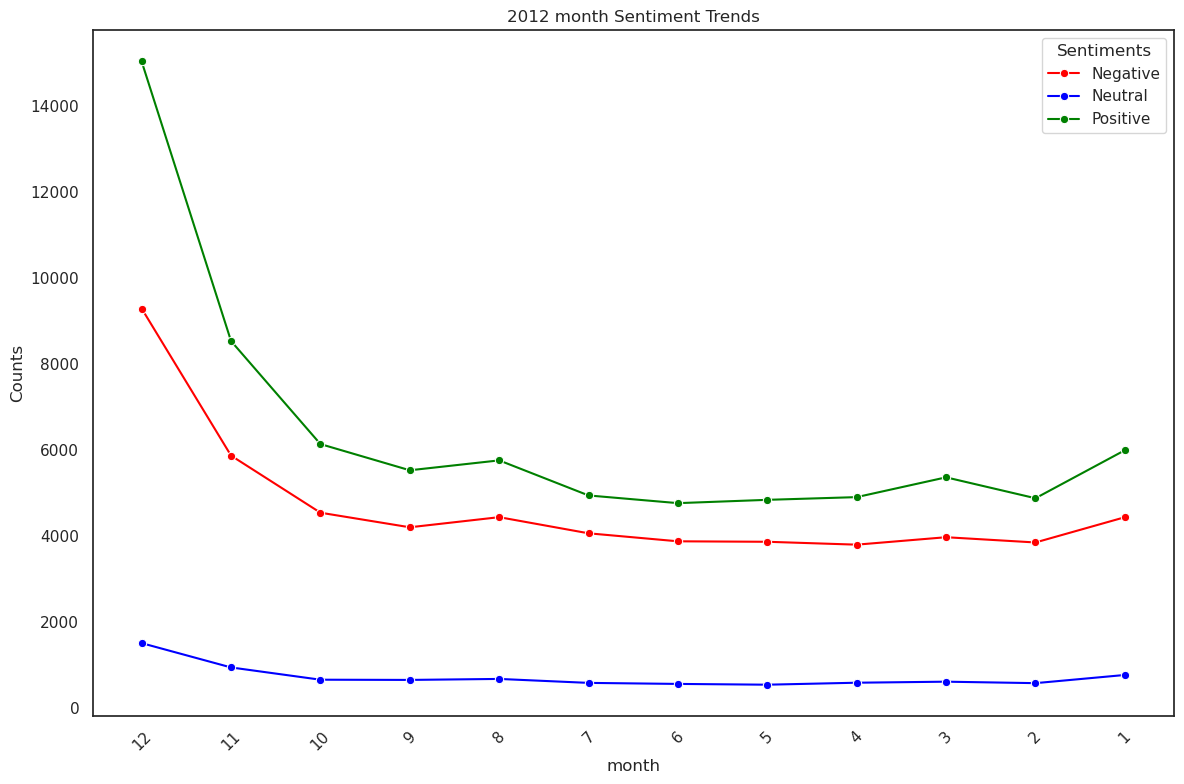

In [94]:
# Set the style
sns.set(style="white")

# Plot
plt.figure(figsize=(12, 8))

# Plotting each sentiment trend
sns.lineplot(x='month', y='negative', data=pdf, marker='o', label='Negative', color='red')
sns.lineplot(x='month', y='neutral', data=pdf, marker='o', label='Neutral', color='blue')
sns.lineplot(x='month', y='positive', data=pdf, marker='o', label='Positive', color='green')

# Adding labels and title
plt.xlabel('month')
plt.ylabel('Counts')
plt.title('2012 month Sentiment Trends')
plt.xticks(rotation=45)
plt.legend(title='Sentiments')

# Show the plot
plt.tight_layout()
plt.show()

### Trend Analysis in 2005

In [102]:
selected_df_2005 = selected_df.filter(F.year("date").alias("year") == 2005)
monthly_counts = selected_df_2005.groupBy(F.month("date").alias("month"), F.year("date").alias("year"), "sentiment_result").count().orderBy(F.desc("year"), "month", "sentiment_result")
pivot_data = monthly_counts.groupBy("year", "month").pivot("sentiment_result").sum("count")
pivot_data.orderBy(F.desc("month")).show()

+----+-----+--------+-------+--------+
|year|month|negative|neutral|positive|
+----+-----+--------+-------+--------+
|2005|   12|     562|    100|     731|
|2005|   11|     544|     88|     674|
|2005|   10|     601|    117|     839|
|2005|    9|     660|    116|     967|
|2005|    8|     867|    138|    1231|
|2005|    7|     699|    131|     915|
|2005|    6|     610|    115|     799|
|2005|    5|     649|    106|     882|
|2005|    4|     581|    106|     844|
|2005|    3|     699|    122|     810|
|2005|    2|     671|    103|     819|
|2005|    1|     640|     93|     781|
+----+-----+--------+-------+--------+



In [103]:
pdf = pivot_data.toPandas()
pdf = pdf.sort_values('month', ascending=False)
pdf['month'] = pdf['month'].astype(str)

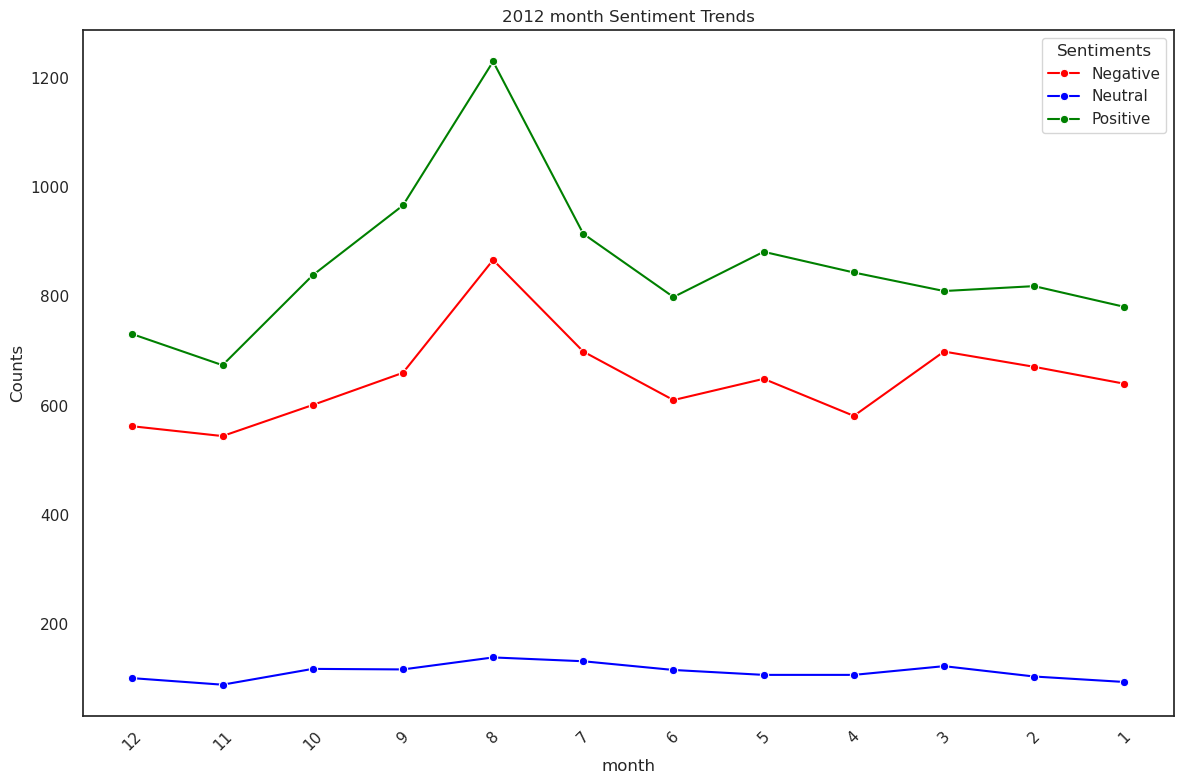

In [104]:
# Set the style
sns.set(style="white")

# Plot
plt.figure(figsize=(12, 8))

# Plotting each sentiment trend
sns.lineplot(x='month', y='negative', data=pdf, marker='o', label='Negative', color='red')
sns.lineplot(x='month', y='neutral', data=pdf, marker='o', label='Neutral', color='blue')
sns.lineplot(x='month', y='positive', data=pdf, marker='o', label='Positive', color='green')

# Adding labels and title
plt.xlabel('month')
plt.ylabel('Counts')
plt.title('2005 month Sentiment Trends')
plt.xticks(rotation=45)
plt.legend(title='Sentiments')

# Show the plot
plt.tight_layout()
plt.show()

### Trend Analysis in 2014

In [166]:
selected_df.printSchema()

root
 |-- product_id: string (nullable = true)
 |-- review_date: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- sentiment_result: string (nullable = true)
 |-- date: date (nullable = true)
 |-- label: double (nullable = false)



In [ ]:
selected_df_2014 = selected_df.filter(F.year("date").alias("year") == 2014)
monthly_counts = selected_df_2014.groupBy(F.month("date").alias("month"), F.year("date").alias("year"), "sentiment_result").count().orderBy(F.desc("year"), "month", "sentiment_result")
pivot_data = monthly_counts.groupBy("year", "month").pivot("sentiment_result").sum("count")
# pivot_data.orderBy(F.desc("month")).show()
pdf = pivot_data.toPandas()
pdf = pdf.sort_values('month', ascending=False)
pdf['month'] = pdf['month'].astype(str)

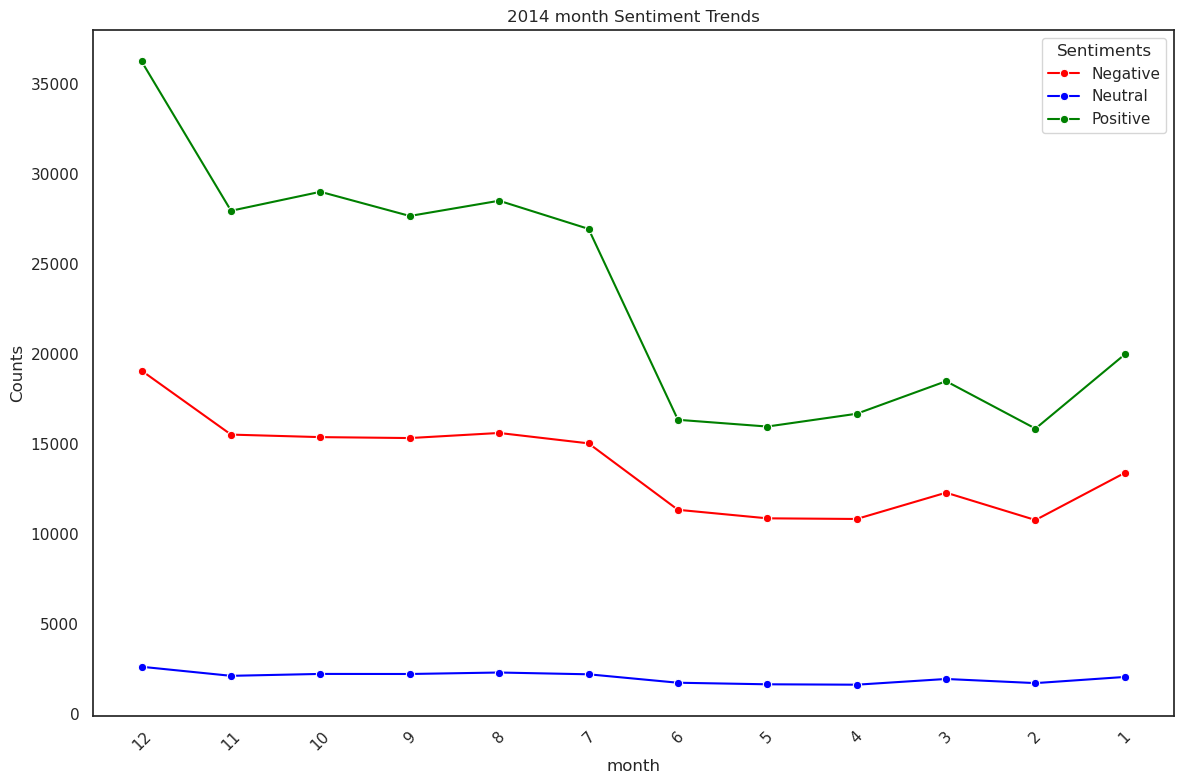

In [89]:
# Set the style
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

# Plot
plt.figure(figsize=(12, 8))

# Plotting each sentiment trend
sns.lineplot(x='month', y='negative', data=pdf, marker='o', label='Negative', color='red')
sns.lineplot(x='month', y='neutral', data=pdf, marker='o', label='Neutral', color='blue')
sns.lineplot(x='month', y='positive', data=pdf, marker='o', label='Positive', color='green')

# Adding labels and title
plt.xlabel('month')
plt.ylabel('Counts')
plt.title('2014 month Sentiment Trends')
plt.xticks(rotation=45)
plt.legend(title='Sentiments')

# Show the plot
plt.tight_layout()
plt.show()

## Correlation between Product and Sentiment Result

In [169]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count as sql_count

# Group by product_id and sentiment_result and count occurrences
grouped = selected_df.select('product_id', 'sentiment_result').groupBy('product_id', 'sentiment_result').count()

# Calculate total reviews per product
total_reviews = grouped.groupBy('product_id').agg(sql_count('sentiment_result').alias('total_reviews'))

# Join with the original grouped data to get proportions
result = grouped.join(total_reviews, 'product_id')
result = result.withColumn('proportion', col('count') / col('total_reviews'))

# Select and show the result
result.select('product_id', 'sentiment_result', 'proportion').show()

+----------+----------------+------------------+
|product_id|sentiment_result|        proportion|
+----------+----------------+------------------+
|B007BEHSDU|         neutral| 9.333333333333334|
|B007BEHSDU|        negative|51.666666666666664|
|B007BEHSDU|        positive| 97.33333333333333|
|B00DY8JEPC|        negative|               1.0|
|B00DY8JEPC|        positive|               2.0|
|B00078ZHPS|         neutral|3.6666666666666665|
|B00078ZHPS|        positive|35.333333333333336|
|B00078ZHPS|        negative|15.333333333333334|
|B00C592H1O|        positive|               0.5|
|B00C592H1O|        negative|               2.0|
|B00B5TL2C0|         neutral|1.3333333333333333|
|B00B5TL2C0|        negative| 5.333333333333333|
|B00B5TL2C0|        positive|2.3333333333333335|
|B00FSKX1XK|        positive|2.3333333333333335|
|B00FSKX1XK|         neutral|0.3333333333333333|
|B00FSKX1XK|        negative|1.3333333333333333|
|B00JLI73ZM|        negative|3.3333333333333335|
|B00JLI73ZM|        

In [170]:
from pyspark.sql import Window
from pyspark.sql.functions import sum as sql_sum

# Assuming 'result' is your current DataFrame as per the previous code
# Calculate the total sum of proportions for each product
windowSpec = Window.partitionBy('product_id')
result_with_total = result.withColumn('total_proportion', sql_sum('proportion').over(windowSpec))

# Normalize the proportions so that they add up to 100% for each product
normalized_result = result_with_total.withColumn('normalized_proportion', (col('proportion') / col('total_proportion')) * 100)

# Select and show the result
normalized_result.select('product_id', 'sentiment_result', 'normalized_proportion').show()


+----------+----------------+---------------------+
|product_id|sentiment_result|normalized_proportion|
+----------+----------------+---------------------+
|0741631016|        negative|                100.0|
|1847503179|        negative|                 25.0|
|1847503179|         neutral|                 25.0|
|1847503179|        positive|                 50.0|
|1890703338|        positive|                81.25|
|1890703338|        negative|                18.75|
|6003003065|        negative|                100.0|
|B00000ISF6|        negative|   16.666666666666664|
|B00000ISF6|        positive|    83.33333333333334|
|B000046S39|        positive|   13.333333333333334|
|B000046S39|        negative|    86.66666666666667|
|B00004DSDC|        negative|   35.714285714285715|
|B00004DSDC|        positive|    53.57142857142857|
|B00004DSDC|         neutral|   10.714285714285714|
|B00004WJSJ|         neutral|    9.090909090909092|
|B00004WJSJ|        negative|   30.303030303030305|
|B00004WJSJ|

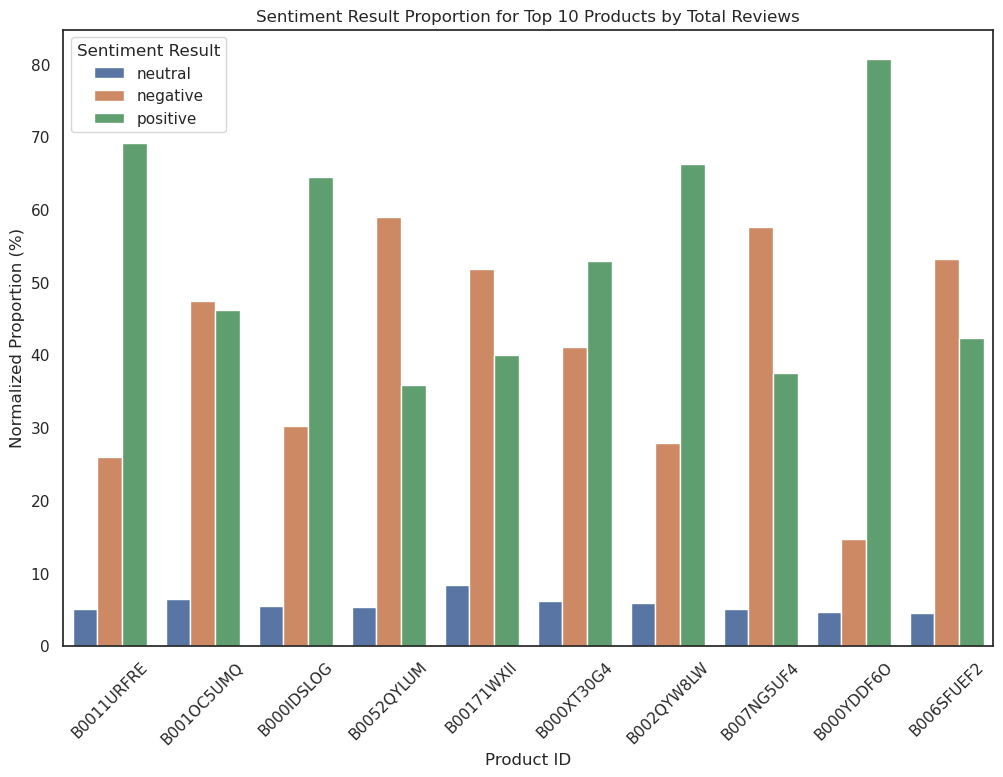

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Identify the top 10 products based on the total number of reviews
total_reviews_per_product = selected_df.select('product_id', 'sentiment_result').groupBy('product_id').count().withColumnRenamed('count', 'total_reviews')
top_10_products = total_reviews_per_product.orderBy('total_reviews', ascending=False).limit(10)

# Step 2: Aggregate and normalize the sentiment proportions for these products
# (continuing from the previous normalization code)
normalized_result_top_10 = normalized_result.join(top_10_products, 'product_id')

# Step 3: Convert to Pandas DataFrame for visualization
pandas_df = normalized_result_top_10.toPandas()

# Step 4: Visualization using Matplotlib/Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='product_id', y='normalized_proportion', hue='sentiment_result', data=pandas_df)
plt.title('Sentiment Result Proportion for Top 10 Products by Total Reviews')
plt.xlabel('Product ID')
plt.ylabel('Normalized Proportion (%)')
plt.xticks(rotation=45)
plt.legend(title='Sentiment Result')
plt.show()


In [176]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg

# Assuming your Spark session is initialized as 'spark' and DataFrame as 'df'

# List of product IDs for which to calculate the average star rating
product_ids = ["B0011URFRE", "B001OC5UMQ","B000IDSLOG","B0052QYLUM", "B00171WXII", "B000XT30G4","B002QYW8LW","B007NG5UF4","B000YDDF6O","B006SFUEF2"]

# Filter the DataFrame for the specified product IDs
data_text_filtered = data_text.filter(data_text.product_id.isin(product_ids))

# Calculate the average star rating for these products
average_rating = data_text_filtered.groupBy("product_id").agg(avg("star_rating").alias("avg_star_rating"))

# Show the results
average_rating.show()

+----------+------------------+
|product_id|   avg_star_rating|
+----------+------------------+
|B0011URFRE| 4.264027538726334|
|B001OC5UMQ| 4.193286410395236|
|B000IDSLOG|4.2506564330438295|
|B0052QYLUM| 3.874745228830832|
|B00171WXII| 4.656218402426694|
|B000XT30G4| 4.474197480698903|
|B002QYW8LW| 4.681949607600165|
|B007NG5UF4|3.9677570093457946|
|B006SFUEF2|3.8251057827926656|
|B000YDDF6O| 4.730280373831776|
+----------+------------------+



In [179]:
data_text.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)



In [180]:

# List of product IDs for which to calculate the average star rating
product_ids = ["B0052QYLUM", "B00171WXII", "B007NG5UF4","B006SFUEF2"]

# Filter the DataFrame for the specified product IDs
data_text_filtered = data_text.filter(data_text.product_id.isin(product_ids))

# Calculate the average star rating for these products
average_rating = data_text_filtered.groupBy("product_id","product_category").agg(avg("star_rating").alias("avg_star_rating"))

# Show the results
average_rating.show()


+----------+----------------+------------------+
|product_id|product_category|   avg_star_rating|
+----------+----------------+------------------+
|B0052QYLUM|            baby| 3.874745228830832|
|B00171WXII|            baby| 4.656218402426694|
|B006SFUEF2|            baby|3.8251057827926656|
|B007NG5UF4|            baby|3.9677570093457946|
+----------+----------------+------------------+

